# Przeskalowanie współrzędnych detekcji do oryginalnych rozmiarów

## Uzasadnienie

Detekcje przeprowadzane są na ograniczonym obrazie (ograniczenie wysokości) i współrzędne te są w pewien sposób przeskalowane względem oryginalnych obrazów. Należy dokonać konwersji w drugą stronę.

## Wczytanie danych

In [24]:
from haar_students_new import non_max_suppression
import cv2

import matplotlib.pyplot as plt
from haar_students_new import draw_bounding_boxes
from haar_students_new import resize_image

def reduce_by_threshold(image_row, **kwargs):
    threshold = kwargs['threshold']
    detections = np.array(image_row[2])
    if detections.ndim == 1:
        return (image_row[0], image_row[1], detections)
    
    detections_reduced = detections[np.where(detections[:, 3] > threshold)].astype('int')
    return (image_row[0], image_row[1], detections_reduced)

def bounding_boxes_reduction(image_row):
    detections = image_row[2]
    detections_reduced = non_max_suppression(detections, treshold=0.1)
    return (image_row[0], image_row[1], detections_reduced)

def batch_drawing(image_row, resize=True):
    file_path = image_row[0]
    ground_truth = image_row[1]
    detections = image_row[2]
    ground_truth = [[bb[1], bb[0], bb[2] - bb[0] - 1, None] for bb in ground_truth]
    
    i = cv2.imread(file_path)
    if resize:
        i = resize_image(i)
    i = draw_bounding_boxes(i, detections, color=(54, 193, 56), thickness=2)
    i = draw_bounding_boxes(i, ground_truth, color=(70, 8, 210), thickness=2)
    
    plt.imshow(i)

## Postprocessing detekcji

In [25]:
from validating_all_images import unpickle_data
coords = unpickle_data("combined_coords_10th_fold.pickle")
import numpy as np
coords = np.array(coords, dtype=object)
coords_filtered = np.apply_along_axis(reduce_by_threshold, 1, coords, threshold=2.5)
coords_suppresion = np.apply_along_axis(bounding_boxes_reduction, 1, coords_filtered)

## Skalowanie

```
def resize_image(i):
    width = int(np.round(i.shape[1] * DEF_HEIGHT / (1.0 * i.shape[0])))
    i = cv2.resize(i, (width, DEF_HEIGHT))
    return i
```

In [26]:
def scale_detections(image_row):
    detections = image_row[2]
    file_path = image_row[0]
    i = cv2.imread(file_path)
    height = i.shape[1]
    scaled_height = 480 # to do read
    s = height/480
    detections_scales = [(int(np.round(k*s)), int(np.round(j*s)), int(np.round(w*s)), d) for (k, j, w, d) in detections]
    return (image_row[0], image_row[1], detections_scales)

coords_scaled = np.apply_along_axis(scale_detections, 1, coords_suppresion)

## Podgląd skalowanych danych

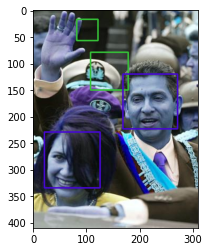

In [50]:
batch_drawing(coords_scaled[9], resize=False)

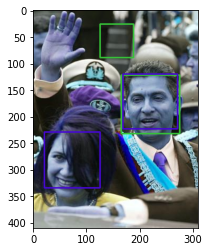

In [48]:
batch_drawing(coords_suppresion[9], resize=False)

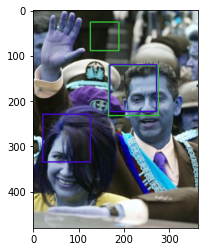

In [49]:
batch_drawing(coords_suppresion[9], resize=True)